In [1]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import shutil
import random
import time
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchsummary import summary
from torchvision import transforms, datasets

In [2]:
def plot_wb(model, fig_path, ranges=None):

    tmp = list(model.named_parameters())
    layers = []
    for i in range(0, len(tmp), 2):
          w, b = tmp[i], tmp[i + 1]
          if ("conv" in w[0] or "conv" in b[0]) or ("fc" in w[0] or "fc" in b[0]):
            layers.append((w, b))

    num_rows = len(layers)

    fig = plt.figure(figsize=(20, 40))

    i = 1
    for w, b in layers:
        w_flatten = w[1].flatten().detach().cpu().numpy()
        b_flatten = b[1].flatten().detach().cpu().numpy()

        fig.add_subplot(num_rows, 2, i)
        plt.title(w[0])
        plt.hist(w_flatten, bins=100, range=ranges);

        fig.add_subplot(num_rows, 2, i + 1)
        plt.title(b[0])
        plt.hist(b_flatten, bins=100, range=ranges);

        i += 2
    
    fig.tight_layout()
    plt.savefig(fig_path)
    plt.close()

def set_all_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

# I/ Dataset

In [3]:
def load_mnist(BATCH_SIZE=64):
    transform = transforms.Compose([transforms.Resize((32,32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5], std=[0.5])])
            
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
    
    # Clear downloading message.
    clear_output()
    
    # Split dataset into training set and validation set.
    train_dataset, val_dataset = random_split(train_dataset, (55000, 5000))
    
    print("Image Shape: {}".format(train_dataset[0][0].numpy().shape), end = '\n\n')
    print("Training Set:   {} samples".format(len(train_dataset)))
    print("Validation Set:   {} samples".format(len(val_dataset)))
    print("Test Set:       {} samples".format(len(test_dataset)))
    
    # Create iterator.
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
    
    # Delete the data/ folder.
    shutil.rmtree('./data')
    
    return (train_loader, val_loader, test_loader)

In [4]:
train_loader, val_loader, test_loader = load_mnist()

Image Shape: (1, 32, 32)

Training Set:   55000 samples
Validation Set:   5000 samples
Test Set:       10000 samples


# II/ Model

In [5]:
class LeNet5(nn.Module):
    
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.dense1 = nn.Linear(16*5*5, 120)
        self.dense2 = nn.Linear(120, 84)
        self.dense3 = nn.Linear(84, self.num_classes)  
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)

        x = x.view(-1, 16*5*5)
        
        x = torch.relu(self.dense1(x))
        x = torch.relu(self.dense2(x))
        x = self.dense3(x)
    
        return x

In [6]:
model = LeNet5()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         AvgPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         AvgPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


# III/ Train

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)

In [8]:
def train(model, EPOCHS, NB_TRAIN_EXAMPLES, NB_VAL_EXAMPLES):
    train_costs, val_costs = [], []

    #Training phase.
    for epoch in range(EPOCHS):

        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Train Acc':^12} | {'Val Loss':^10} | {'Val Acc':^10} | {'Elapsed':^9}")
        print("-"*85)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        #------------------------------------------------
        #                 TRAINING
        #------------------------------------------------

        train_loss, correct_train = 0, 0
        batch_loss, correct_batch, batch_counts = 0, 0, 0
        
        if device == "cuda":
          model.train().cuda()
        
        for step, (inputs, labels) in enumerate(train_loader):
            
            # Load data to GPU.
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients.
            optimizer.zero_grad()
            
            # Forward pass.
            prediction = model(inputs)
            
            # Compute the loss.
            loss = criterion(prediction, labels)
            
            # Backward pass.
            loss.backward()
            
            # Optimize.
            optimizer.step()
            
            # Compute training accuracy.
            _, predicted = torch.max(prediction.data, 1)
            correct_train += (predicted == labels).sum().item()
            correct_batch += (predicted == labels).sum().item()
            
            # Compute batch loss.
            batch_loss += (loss.data.item() * inputs.shape[0])
            train_loss += (loss.data.item() * inputs.shape[0])

            # Print the loss values and time elapsed for every 20 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_loader) - 1):
                
                time_elapsed = time.time() - t0_batch

                print(f"{epoch + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {correct_batch / batch_counts:^12.6f} | {'-':^10} | {'-':^10} |  {time_elapsed:^9.2f}")
                batch_loss, correct_batch, batch_counts = 0, 0, 0
                t0_batch = time.time()

            batch_counts += inputs.shape[0]

        train_loss /= NB_TRAIN_EXAMPLES
        train_costs.append(train_loss)
        train_acc =  correct_train / NB_TRAIN_EXAMPLES

        print("-"*85)

        #------------------------------------------------
        #                 VALIDATION
        #------------------------------------------------

        val_loss = 0
        correct_val = 0
        
        if device == "cuda":
          model.eval().cuda()
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                # Load data to GPU.
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass.
                prediction = model(inputs)

                # Compute the loss.
                loss = criterion(prediction, labels)

                # Compute training accuracy.
                _, predicted = torch.max(prediction.data, 1)
                correct_val += (predicted == labels).sum().item()

                # Compute batch loss.
                val_loss += (loss.data.item() * inputs.shape[0])

            val_loss /= NB_VAL_EXAMPLES
            val_costs.append(val_loss)
            val_acc =  correct_val / NB_VAL_EXAMPLES

        time_elapsed = time.time() - t0_epoch

        info = "[Epoch {}/{}]: train-loss = {:0.6f} | train-acc = {:0.6f} | val-loss = {:0.6f} | val-acc = {:0.6f} | time_elapsed = {:0.2f}"
        print(info.format(epoch+1, EPOCHS, train_loss, train_acc, val_loss, val_acc, time_elapsed))
                                                                
    # torch.save(model.state_dict(), 'nn_model')  
    return train_costs, val_costs

In [9]:
EPOCHS = 13
NB_TRAIN_EXAMPLES = len(train_loader.dataset)
NB_VAL_EXAMPLES = len(val_loader.dataset)

set_all_seed(42)
train_costs, val_costs = train(model, EPOCHS, NB_TRAIN_EXAMPLES, NB_VAL_EXAMPLES)

 Epoch  |  Batch  |  Train Loss  |  Train Acc   |  Val Loss  |  Val Acc   |  Elapsed 
-------------------------------------------------------------------------------------
   1    |   100   |   2.325321   |   0.103125   |     -      |     -      |    1.34   
   1    |   200   |   2.298624   |   0.123438   |     -      |     -      |    1.20   
   1    |   300   |   2.292417   |   0.152969   |     -      |     -      |    1.21   
   1    |   400   |   2.283349   |   0.112656   |     -      |     -      |    1.19   
   1    |   500   |   2.263145   |   0.126094   |     -      |     -      |    1.20   
   1    |   600   |   2.201249   |   0.215469   |     -      |     -      |    1.20   
   1    |   700   |   1.868959   |   0.462656   |     -      |     -      |    1.19   
   1    |   800   |   0.954828   |   0.736250   |     -      |     -      |    1.18   
   1    |   859   |   0.610964   |   0.805879   |     -      |     -      |    0.72   
---------------------------------------------

In [10]:
plot_wb(model, fig_path="normal-training.png")

# IV/ Plot

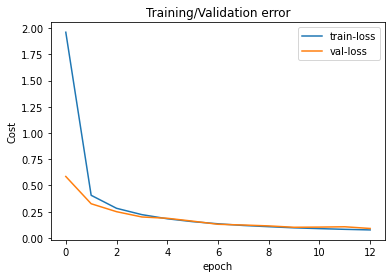

In [11]:
plt.title('Training/Validation error')
plt.ylabel('Cost')
plt.xlabel('epoch')

plt.plot(train_costs)
plt.plot(val_costs)
plt.legend(['train-loss', 'val-loss'], loc='upper right')
plt.show()